# Which video streaming stocks are worth investing post-COVID?
### *Time Series Analysis using ARIMA models to forecast stock price data*
### By: Nathan Hufano

#### Table of Contents

1. [Introduction](#1)
2. [Methodology](#2)
3. [Data Collection](#3)
4. [Processing the Data](#4)
5. [Visualizing the Data](#5)
    * [General Descriptive Statistics](#6)
    * [Graphical Representation Overview](#7)
6. [Analyzing the Data](#8) 
    * [Using the `pmdarima` package on Netflix (NFLX) data](#9)
    * [Fitting ARIMA models on remaining stock tickers](#10)
    * [Forecasting values beyond the given timeframe](#11)
7. [Conclusions](#12)
8. [References](#13)

<a id='1'></a>
# Introduction

### Motivation of research question
In the past decade, Netflix has dominated the video streaming market due to their library content, flexibility in consuming content, and lack of competition. However, in recent years there are new video streaming services available that are competing against Netflix which has cause competition in today's streaming wars. When COVID-19 lockdown procedures began and people were stuck at home, video streaming was one of few commodities that kept people entertained which led to have a massive uptick in its usage. Investors plan on putting money into these streaming services due to the potential of achieving a profit. 

Now that COVID procedures are lax and people are enjoying life outside their homes again, is it still viable to invest in video streaming stocks post-COVID? And if so, which are worth investing into? 

<a id='2'></a>
# Methodology
According to [Investopedia](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp), Auto Regressive Integrated Moving Average model (ARIMA) is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. They are one of many machine learning techniques that can analyze and predict future stock prices based on its historical prices. 

The acronym of ARIMA stands for:

* **Autoregression (AR)**: refers to a model that shows a changing variable that regresses on its own lagged, or prior values
* **Integrated (I)**: represents the difference of raw observations to allow for the time series to become stationary (i.e., data values are replace by the difference between the data values and the previous values)
* **Moving Average (MA)**: incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations

ARIMA models have three order parameters $(p, d, q)$ where:

* $p$ is the number of lag observations in the model for the AR term
* $d$ is the number of differencing required to make the time series stationary
* $q$ is the size of the MA window

The drawback of using ARIMA models is that it assumes that the future will resemble the past data. The future is uncertain, especially with the volatility of the stock market.

Although there are advantages and disadvantages of using ARIMA models, this notebook will attempt to use such models as a good starting point in guesstimating the future values of stock price data.

<a id='3'></a>
# Data Collection

In [1]:
# Necessary packages used throughout the notebook
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Using the [CDC Museum COVID-19 Timeline](https://www.cdc.gov/museum/timeline/covid19.html#:~:text=March%2015%2C%202020%20US,of%20COVID%2D19), the US began its lockdown procedures on March 15, 2020 to prevent the spread of COVID-19. (*In my opinion*) this was the start when people were trying to occupy themselves and so begins the timeframe of collecting data. 

The end date for data collection is March 15, 2022, exactly 2 years later. US COVID lockdown procedures were lifted before this date and so it is reasonable to choose the end date as such as it is difficult to define the post-COVID date.

In [2]:
# start and end date values for data collection
start = datetime.datetime(2020,3,15)
end = datetime.datetime(2022,3,15)

The stock tickers used will be ones that have famous brand recognition. 

For comparison, below is a table of the name of the company, its corresponding stock ticker, and its streaming service. 

| Company | Stock Ticker | Name of Streaming Service |
|:--------|:-------------|:--------------------------|
| Netflix | NFLX         | Netflix                   |
| Disney  | DIS          | Disney+                   |
| Apple   | AAPL         | Apple TV+                 |
| Comcast | CMCSA        | Peacock                   |
| Roku    | ROKU         | Roku                      |
| AT&T    | T            | HBO Max                   |

In [3]:
# list of video stock ticker symbols used for analysis
stocktickers = ['NFLX', 'DIS', 'AAPL', 'CMCSA', 'ROKU', 'T']

Historical stock market data can be obtained by using functions from the `yfinance` package. The **Closed** Price columns will be used as it is [a nice indicator in assessing change in stock prices over time](https://www.investopedia.com/terms/c/closingprice.asp). A list comprehension is used to iterate through all the stated stock tickers retrieving their closed prices from the given timeframe, and later combined into one dataframe.

In [4]:
# get the closing prices of each stock from March 15, 2020 to March 15, 2022
closing_prices = [yf.download(stock, start, end)['Close'] for stock in stocktickers]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# combine the lists then turn into a dataframe
closing_prices = pd.concat(closing_prices, axis=1, sort=False)
closing_prices.columns = stocktickers
closing_prices.head()

,NFLX,DIS,AAPL,CMCSA,ROKU,T
Date,,,,,,
2020-03-16,298.839996,95.010002,60.552502,36.040001,63.840000,24.025681
2020-03-17,319.750000,93.529999,63.215000,38.220001,69.459999,25.483383
2020-03-18,315.470001,88.800003,61.667500,35.680000,67.500000,24.811178
2020-03-19,332.029999,94.930000,61.195000,35.939999,74.120003,23.527189
2020-03-20,332.829987,85.980003,57.310001,33.369999,76.129997,21.487915


<a id='4'></a>
# Processing the Data

Before proceeding, various methods are used to make sure the data obtained is clean and usable. The following code snippit is to check for null values in the dataset were no such values were found.

In [6]:
# finds null values in dataset
closing_prices.isnull().sum()

NFLX     0
DIS      0
AAPL     0
CMCSA    0
ROKU     0
T        0
dtype: int64

The date format for the closing price dataframe is in YYYY-MM-DD. In the following code snippet, the given dates are changed to be in full date American notation to make it easier to interprate dates.

In [7]:
# format date to be in full date American notation
closing_prices.index = pd.to_datetime(closing_prices.index, dayfirst=True)
closing_prices.index = closing_prices.index.strftime('%b %d, %Y')
closing_prices.head()

,NFLX,DIS,AAPL,CMCSA,ROKU,T
Date,,,,,,
"Mar 16, 2020",298.839996,95.010002,60.552502,36.040001,63.840000,24.025681
"Mar 17, 2020",319.750000,93.529999,63.215000,38.220001,69.459999,25.483383
"Mar 18, 2020",315.470001,88.800003,61.667500,35.680000,67.500000,24.811178
"Mar 19, 2020",332.029999,94.930000,61.195000,35.939999,74.120003,23.527189
"Mar 20, 2020",332.829987,85.980003,57.310001,33.369999,76.129997,21.487915


Finally, testing and training sets are made to build and evaluate various models. The dataset is split 80/20 for training and testing respectively.

In [8]:
# training and testing datasets
len_cutoff = int(len(closing_prices) * 0.8)
train_data, test_data = closing_prices[:len_cutoff], closing_prices[len_cutoff:]

print(f"{len(train_data)} train samples")
print(f"{len(test_data)} test samples")

403 train samples
101 test samples


<a id='5'></a>
# Visualizing the Data

<a id='6'></a>
## General descriptive statistics

In [9]:
closing_prices.describe()

,NFLX,DIS,AAPL,CMCSA,ROKU,T
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,509.643293,152.306805,127.095764,49.325595,258.267709,21.343497
std,75.474112,28.732499,29.306798,6.945324,110.576848,1.718086
min,298.839996,85.760002,56.092499,32.419998,63.840000,16.744713
25%,480.585007,126.922499,114.939373,44.315001,152.835003,20.547583
50%,509.094986,154.705002,128.165001,50.350000,249.235001,21.737160
75%,547.640015,177.009998,147.882496,55.082501,347.734993,22.537764
max,691.690002,201.910004,182.009995,61.750000,479.500000,25.483383


Based on the general descriptive statistics, all stock tickers differ in prices. The average price of NFLX, DIS, AAPL, and ROKU are in the hundreds place while CMCSA and T are in the tens place.

<a id='7'></a>
## Graphical representation overview

We can easily view these prices as plotted figures using visualization packages such as `matplotlib`.

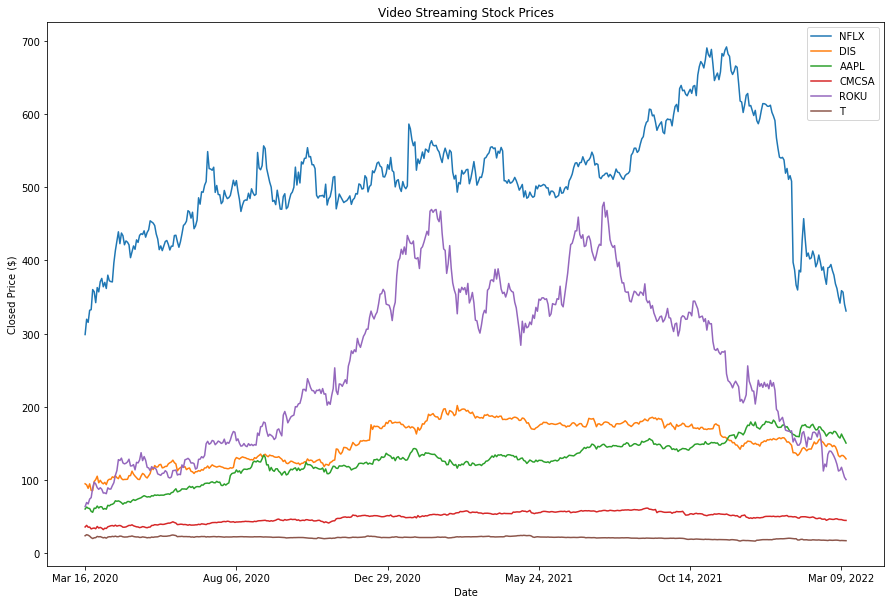

In [10]:
closing_prices.plot(figsize=(15,10), title='Video Streaming Stock Prices', ylabel='Closed Price ($)')
plt.show()

NFLX has increased and decreases in the past 2 years but around October 2021 the stock goes on a downward trend.

ROKU also has a similar trend as NFLX but the downward trend happens early around July-August 2021.

The other stocks seem to stablize towards the end but the stock price history of both NFLX and ROKU may distort the plot. We temporarily exclude these stock tickers so that we can compare the other stocks  closely.

<AxesSubplot:xlabel='Date', ylabel='Closed Price ($)'>

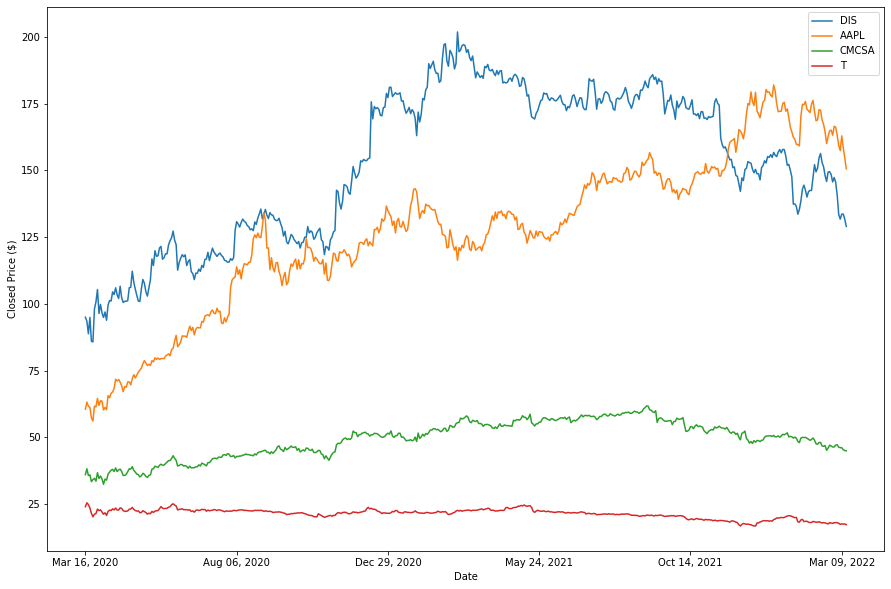

In [11]:
exclude_Col = ['NFLX','ROKU']
closing_prices.loc[:, ~closing_prices.columns.isin(exclude_Col)].plot(figsize=(15,10), ylabel='Closed Price ($)')

DIS stock has a downward trend with a dip in October 2021 but not as extreme as NFLX and ROKU.

APPL stock is steadily increasing that it surpassed DIS stock around December 2021. Has a bit of a downward trend towards the end of March 2022.

Like before, the other stocks seem to stablize towards the end but the high priced stocks may distort the plot. Temporarily excludng these stock tickers can make reading the graph easier.


<AxesSubplot:xlabel='Date', ylabel='Closed Price ($)'>

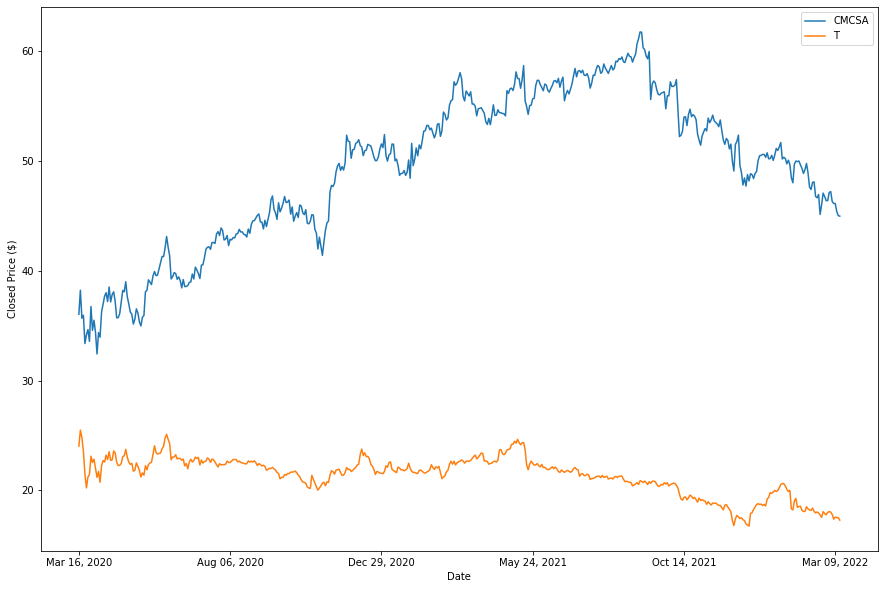

In [12]:
exclude_Col.append('DIS')
exclude_Col.append('AAPL')
closing_prices.loc[:, ~closing_prices.columns.isin(exclude_Col)].plot(figsize=(15,10), ylabel='Closed Price ($)')

After inspecting the historical closing prices, it seems to be that the video streaming stocks are heading  in a downward direction. Fitting various ARIMA models and forecasting its future values can try to confirm the observation.

<a id='8'></a>
# Analyzing the Data

<a id='9'></a>
## 1) Using the `pmdarima` package on Netflix (NFLX) data

The `pmdarima` package has made the checking and implementation of ARIMA models with ease. 

For example, the statistical test [Augmented Dickey Fuller Test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) (ADF Test) is used to determine if a time series is stationary. 

It is important to use the ADF test to find the $d$ value of an ARIMA model as it is used to find the minimum number of differencing needed to make the series stationary. If the series is stationary, $d=0$. 

The `adfuller` function from the `statsmodels.tsa.stattools` package can check if differencing is needed but the `ndiffs` function from the `pmdarima` package can automatically run the differencing test to select the best difference number in finding the $d$ value of an ARIMA model. 

In [13]:
# calculate best differencing value using ADF
adf_diffs = ndiffs(train_data['NFLX'].values, alpha=0.05, test='adf', max_d=10)
print(f"Estimated differencing term for NFLX: {adf_diffs}")

Estimated differencing term for NFLX: 1


Autocorrelation and Partial Autocorrelation plots are used to find the AR and MA terms ($q$ and $p$ values respectively) of an ARIMA model. These plots can be created using `plot_acf` and `plot_pacf` functions from `statsmodels.graphics.tsaplots` package.

Instead, the `auto_arima` function with predetermined arguments can automatically find the optimal order for an ARIMA model with the smallest AIC value using stepwise search.

In [14]:
# automatically find the optimal ARIMA model
mod_Netlfix = pm.auto_arima(train_data['NFLX'].values, 
                            d=adf_diffs, # found from using ndiffs()
                            seasonal=False, 
                            max_order=None, 
                            trace=True) #shows how long the stepwise search takes along w/ the model it finds

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3129.259, Time=3.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3138.362, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3132.750, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3132.369, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3138.366, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3130.661, Time=1.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3134.061, Time=1.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3127.256, Time=3.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3127.558, Time=2.76 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3127.486, Time=6.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3126.613, Time=8.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3129.051, Time=4.85 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3128.245, Time=10.16 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3128.214, Time=9.03 sec
 ARIMA(2,1,4)(0,0,0)[0] intercep

The `plot_diagnostics` function determines visually how great the model is fitting the data and if any of the OLS assumptions have been violated.

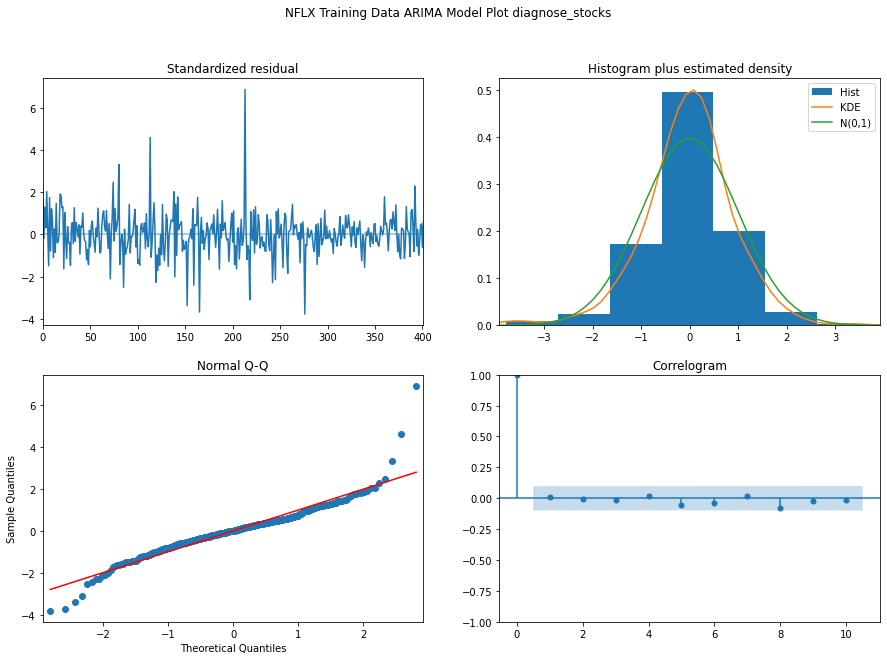

In [15]:
diagnose_Netfilix = mod_Netlfix.plot_diagnostics(figsize=(15,10));
diagnose_Netfilix.suptitle('NFLX Training Data ARIMA Model Plot diagnose_stocks');

<ins>Interpretation of the graphs are as follows:</ins>

**Top Left**: No obvious structure and the residual errors seem to fluctuate around a mean of zero

**Top Right**: The density plot suggest a normal distribution with mean zero

**Bottom Left**: A majority of the dots fall within the red line which assumes the errors are normally distributed

**Bottom Right**: The residual errors are not autocorrelated.

Overall, this model is a good fit for forecasting.

We can now test our model using a test set that was setup earlier. We update our model one day at a time were the latest observed value is shifted as the model goes through several iterations for each new observation.

In [16]:
# stores the predicted values into this list
predictions = []

for new_ob in test_data['NFLX']:
    preds = mod_Netlfix.predict(n_periods=1)
    predictions.append(preds)
    mod_Netlfix.update(new_ob)

Using the collected data, we then compare the training, testing, and predicted values as a plotted figure.

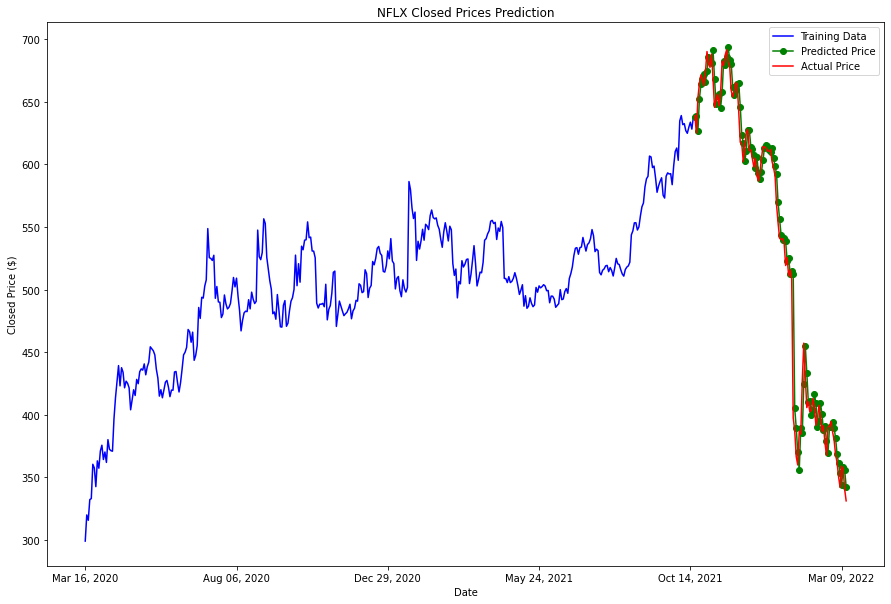

In [17]:
# plot that shows the training, testing, and predicted values of NFLX
plt.figure(figsize=(15,10))
plt.plot(train_data.index, train_data['NFLX'], color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o',label='Predicted Price')
plt.plot(test_data.index, test_data['NFLX'], color='red', label='Actual Price')

# plot labels
plt.title('NFLX Closed Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price ($)')
plt.legend()

# setting the max xticks of the plot
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))

Although the ARIMA model was found automatically, accuracy metrics are still used to compare the the performance of the models. 

Some of these accuracy metrics are:
+ Mean Squared Error (MSE)
+ Root Mean Squared Error (RMSE)
+ Mean Absolute Percentage Error (MAPE)

The following code snippit uses the mentioned accuracy metrics to judge the predictions:

In [18]:
# performing accuracy metrics on NFLX time series forecast
mse = mean_squared_error(test_data['NFLX'], predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_data['NFLX'], predictions)

print(f"NFLX MSE: {mse}")
print(f"NFLX RMSE: {rmse}")
print(f"NFLX MAPE: {mape: 0.3%}")

NFLX MSE: 314.80908508148104
NFLX RMSE: 17.742860115592443
NFLX MAPE:  2.461%


When comparing forecasts of two different series, MAPE is better understandable as its value varies between 0 and 1. It's easier to judge how good the forecast is regardless of the series' scale.

The NFLX training model obtained a MAPE score of around 2.46%, which means the model is 97.54% accurate in predicting the next observation.

Now that I know that the ARIMA model for Netflix is usable, I can apply the model on the entire closed price on Netflix data.

In [19]:
# list that contains the complete ARIMA models on the entire closing price dataset 
models_df = []

# Fitting an ARIMA model on NFLX
arima_Netflix = pm.ARIMA(order=(3,1,3))
arima_Netflix.fit(closing_prices['NFLX'])
models_df.append(arima_Netflix)

/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<a id='10'></a>
## 2) Fitting ARIMA models on remaining stock tickers

#### Calculating the best differencing number using the ADF test from `ndiffs`

In [20]:
# (temporarily) remove Netflix stock ticker as its no longer needed to find ARIMA models
stocktickers.remove('NFLX')

# calculating the best differencing number using ADF test on remaining stock tickers
for stock in stocktickers:
    adf_diffs = ndiffs(train_data[stock].values, alpha=0.05, test='adf', max_d=10)
    print(f"Estimated differencing term for {stock}: {adf_diffs}")

Estimated differencing term for DIS: 1
Estimated differencing term for AAPL: 1
Estimated differencing term for CMCSA: 1
Estimated differencing term for ROKU: 1
Estimated differencing term for T: 1


#### Finding the best ARIMA models on remaining stock tickers training set

In [21]:
# a list that stores the ARIMA models for each stock ticker
train_models = []

# finding the best ARIMA models on remaining stock tickers
for stock in stocktickers:
    model = pm.auto_arima(train_data[stock].values, d=1, seasonal=False, max_order=None, trace=False)
    train_models.append(model)
    print(f'ARIMA Model for {stock}: {model}')

ARIMA Model for DIS:  ARIMA(1,1,1)(0,0,0)[0] intercept
ARIMA Model for AAPL:  ARIMA(0,1,0)(0,0,0)[0] intercept
ARIMA Model for CMCSA:  ARIMA(3,1,3)(0,0,0)[0] intercept
ARIMA Model for ROKU:  ARIMA(0,1,0)(0,0,0)[0]          
ARIMA Model for T:  ARIMA(1,1,4)(0,0,0)[0]          


For comparison, the ARIMA model for NFLX was ` ARIMA(3,1,3)(0,0,0)[0] intercept` which has the same model as CMCSA. AAPL and ROKU also share the same model while the rest of the stocks have unique models.

#### Checking for OLS assumption violations using `plot_diagnose()` on remaining ARIMA models

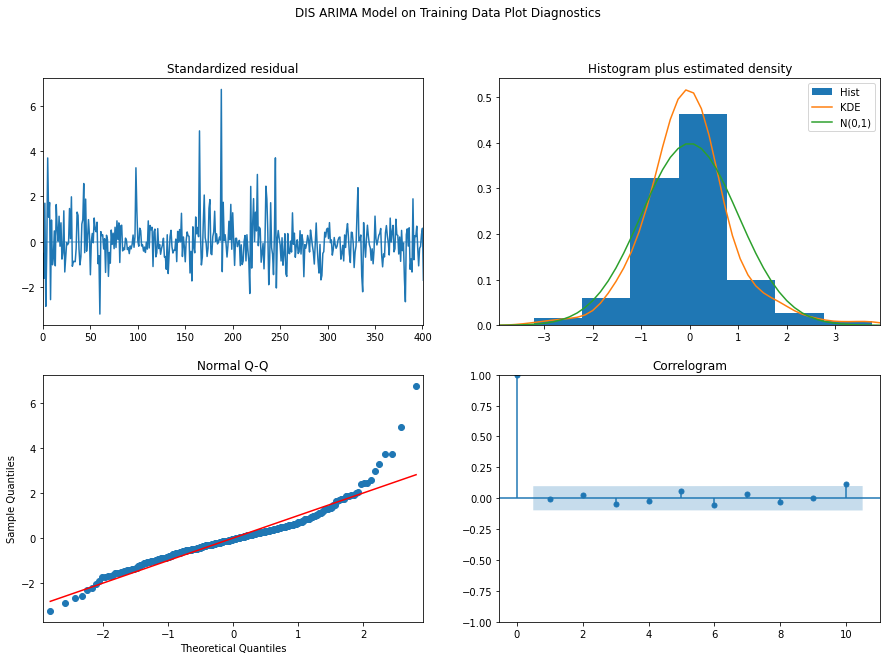

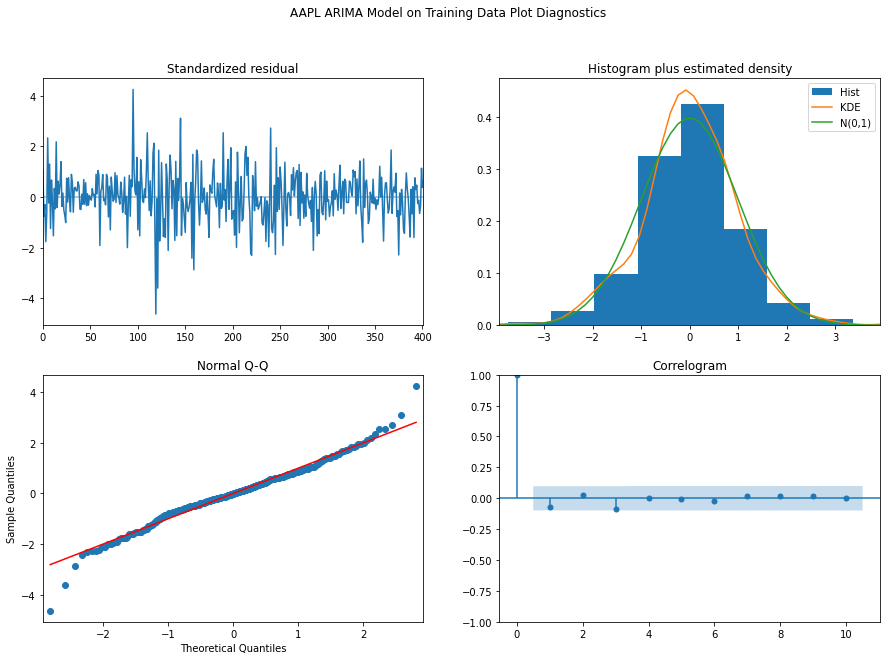

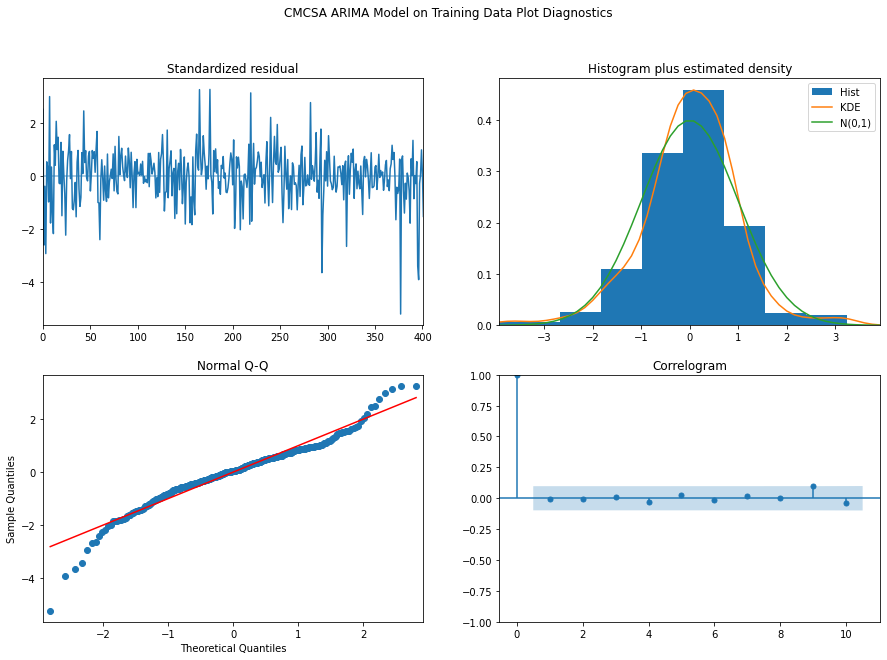

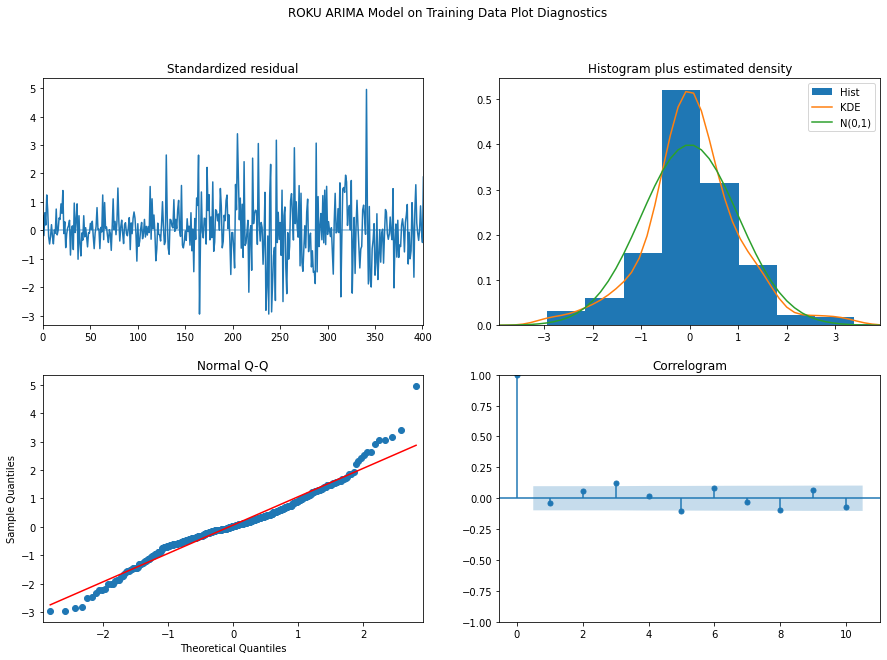

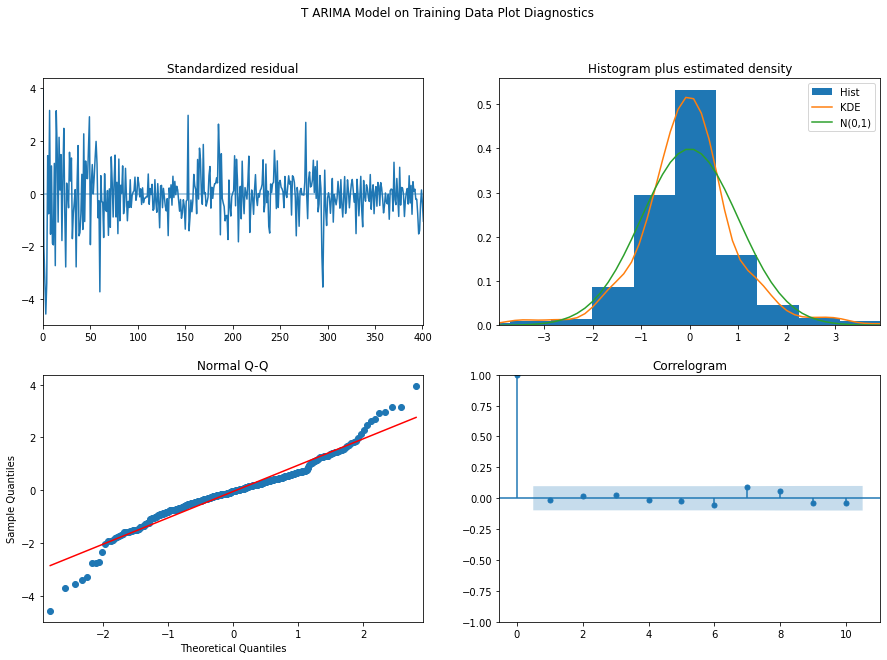

In [22]:
for model, stock in zip(train_models, stocktickers):
    diagnose_stock = model.plot_diagnostics(figsize=(15,10));
    diagnose_stock.suptitle(f'{stock} ARIMA Model on Training Data Plot Diagnostics');

The interpretation of these graphs are similar to the NFLX diagnostic plots. The models overall are safe for forecasting.

#### Calculating prediction values 

In [23]:
# stores the prediction values for later plotting
predictions_all = pd.DataFrame()

for stock, model in zip(stocktickers, train_models):
    predictions = []

    for new_ob in test_data[stock]:
        preds = model.predict(n_periods=1)
        predictions.append(preds)
        model.update(new_ob)

    predictions_all[stock] = predictions

#### Plotting the training, testing, and predicted values of remaining stock tickers

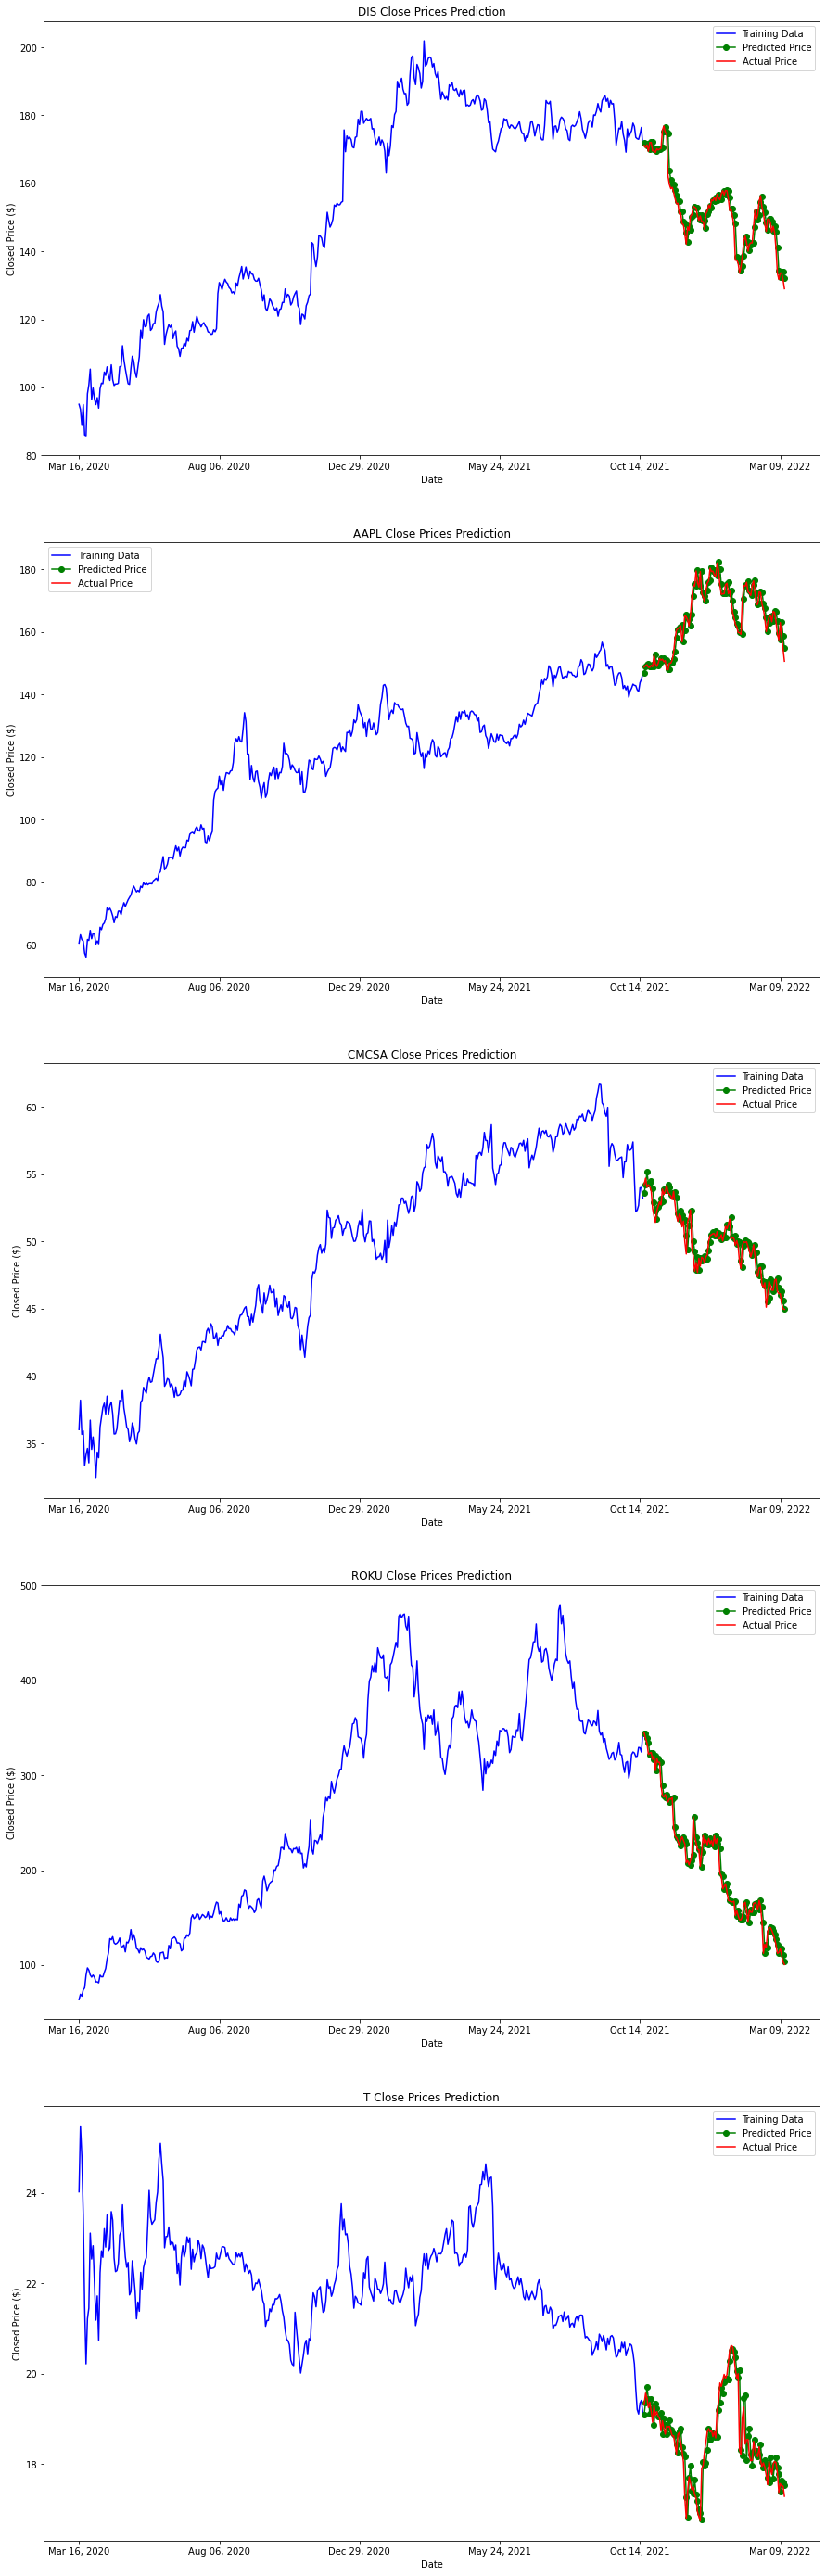

In [24]:
fig, axes = plt.subplots(5, 1, figsize=(15, 50))
for stock, num in zip(stocktickers, range(5)):
    
    # plot that shows the stock ARIMA model predicted values on testing set
    axes[num].plot(train_data.index, train_data[stock], color='blue', label='Training Data')
    axes[num].plot(test_data.index, predictions_all[stock], color='green', marker='o',label='Predicted Price')
    axes[num].plot(test_data.index, test_data[stock], color='red', label='Actual Price')
    
    # labels for the plot
    axes[num].set_title(f'{stock} Close Prices Prediction')
    axes[num].set_xlabel('Date')
    axes[num].set_ylabel('Closed Price ($)')
    axes[num].legend()

    # setting the max xticks of the plots
    axes[num].xaxis.set_major_locator(plt.MaxNLocator(6))

#### Performing accuracy metrics on remaining training models

In [25]:
for stock in stocktickers:
    mse = mean_squared_error(test_data[stock], predictions_all[stock])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test_data[stock], predictions_all[stock])

    print(f"{stock} MSE: {mse}")
    print(f"{stock} RMSE: {rmse}")
    print(f"{stock} MAPE: {mape: 0.3%} \n")

DIS MSE: 8.513397236921042
DIS RMSE: 2.917772649971386
DIS MAPE:  1.434% 

AAPL MSE: 8.626070577410072
AAPL RMSE: 2.9370172926644598
AAPL MAPE:  1.366% 

CMCSA MSE: 0.6240181527876641
CMCSA RMSE: 0.7899481962683782
CMCSA MAPE:  1.213% 

ROKU MSE: 107.09361928488049
ROKU RMSE: 10.348604702320042
ROKU MAPE:  3.898% 

T MSE: 0.12795771958452354
T RMSE: 0.35771178284272875
T MAPE:  1.337% 



For comparison, the NFLX MAPE score was 2.494%. Even with ROKU's MAPE score of 3.898%, the ARIMA model is still <95% accurate for predicting the next observation.

#### Fitting the models on entire closing prices dataset

In [26]:
arima_DIS = pm.ARIMA(order=(1,1,1))
arima_AAPL = pm.ARIMA(order=(0,1,0))
arima_CMCSA = pm.ARIMA(order=(3,1,3))
arima_ROKU = pm.ARIMA(order=(0,1,0))
arima_T = pm.ARIMA(order=(1,1,4))

# put arima models into list for easy iteration
arima_models = [arima_DIS, arima_AAPL, arima_CMCSA, arima_ROKU, arima_T]

# fit arima models based on stock ticker then append to models dataframe
for stockticker, arima in zip(stocktickers, arima_models):
    arima.fit(closing_prices[stockticker])
    models_df.append(arima)

/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<a id='11'></a>
## 3) Forecasting values beyond the given timeframe

In [27]:
# reinsert Netflix stock ticker for plotting
stocktickers.insert(0, 'NFLX')

Forecasting 2 weeks into the future is a relatively safe measure to predict stock values. 

To forecast beyond the given timeframe, we update our models one day at a time (just like what we did for training) were the latest **forecasted** value is shifted as the model goes through several iterations for each new observation.

In [28]:
# how many days to forecast
future_days = 14

# stores forecasted values 
forecast_df = pd.DataFrame()

for stock, model in zip(stocktickers, models_df):

    # stores the forecasted values of stock ticker
    forecast_list = []

    # update model one day at a time for accurate forecasting
    for num in range(1,future_days+1):
        fc_value = model.predict(n_periods=1)
        forecast_list.append(fc_value[0])
        model.update(fc_value[0])
    
    forecast_df[stock] = forecast_list

/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

<AxesSubplot:title={'center':'Future T stock price in the next 14 days'}, xlabel='Forecasted Days', ylabel='Closed Price ($)'>

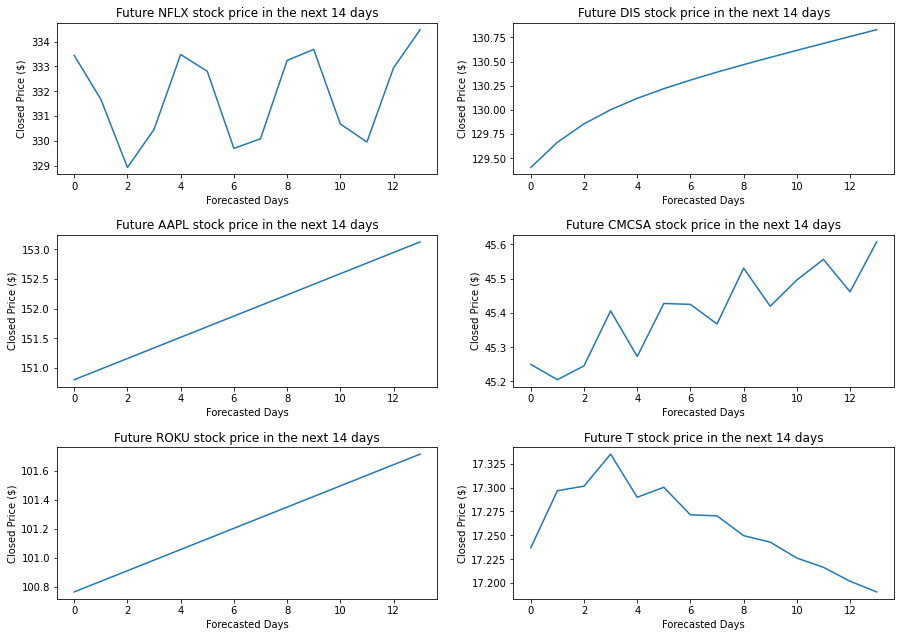

In [29]:
# plotting the forecasted values of each stock ticker
figures, axes = plt.subplots(3, 2, figsize=(15,10))
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)

forecast_df['NFLX'].plot(ax=axes[0,0], title='Future NFLX stock price in the next 14 days', xlabel='Forecasted Days', ylabel='Closed Price ($)')
forecast_df['DIS'].plot(ax=axes[0,1], title='Future DIS stock price in the next 14 days', xlabel='Forecasted Days', ylabel='Closed Price ($)')
forecast_df['AAPL'].plot(ax=axes[1,0], title='Future AAPL stock price in the next 14 days', xlabel='Forecasted Days', ylabel='Closed Price ($)')
forecast_df['CMCSA'].plot(ax=axes[1,1], title='Future CMCSA stock price in the next 14 days', xlabel='Forecasted Days', ylabel='Closed Price ($)')
forecast_df['ROKU'].plot(ax=axes[2,0], title='Future ROKU stock price in the next 14 days', xlabel='Forecasted Days', ylabel='Closed Price ($)')
forecast_df['T'].plot(ax=axes[2,1], title='Future T stock price in the next 14 days', xlabel='Forecasted Days', ylabel='Closed Price ($)')

From the initial observations of the historical stock price data were they showed a downward trend, the forecasted stock price plots tells a different story:

+ CMCSA and NFLX have an erratic display and are seen to have an upward trend. The peaks of both stock increase later in the week were it is more noticable on CMCSA stocks.
+ DIS, AAPL, and ROKU have similar upward trends. Both APPL and ROKU have a steady linear trend while DIS displays a slight upward curve then transforms to a linear trend.
+ T has a peak around day 3 then has a couple peaks and troughs which then settle to a downward trend.

<a id='12'></a>
# Conclusions 
Many interesting insights were found when predicting video streaming stock prices using ARIMA models. From the forecasted plots, it seems worthy to invest in 5/6 stocks as their forecasts are headed in an upward trend. Investors could try to implement a trading strategy in maximizing their returns as each video streaming stocks are priced differently.

### Closing Thoughts
Overall, ARIMA models serve as a good guesstimator in forecasting values and are simple to use. However, using ARIMA models can still be difficult in finding the best correct model. As stated before ARIMA models assume that the future will resemble the past data. 

Although this notebook is complete, there is a significant amount of research and analysis that can be done with this data and topic.

### Disclaimer
*This notebook should not be seen as a trading advice and the purchasing/selling of stocks is done at your own risk.*

<a id='13'></a>
#### References

1. [pmdarima: ARIMA estimators for Python](http://alkaline-ml.com/pmdarima/): Official documentation of the`pmdarima` package 
2. [ARIMA Model for Time Series Forecasting](https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting): Kaggle notebook that gives an introduction to ARIMA models
3. [ARIMA Model - Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/): Similar to the previous reference, an in depth guide to using ARIMA models

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b973441a-3794-4901-9473-99754c0927cd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>